# Lab:15 Deep Reinforcement Learning

In the last lab, we use the tabular method (Q-learning, SARSA) to train an agent to play Flappy Bird with features in environments. However, it is time-costly and inefficient if more features are added to the environment because the agent can not easily generalize its experience to other states that were not seen before. Furthermore, in realistic environments with large state / action space, it requires a large memory space to store all state-action pairs.

In this lab, we introduce deep reinforcement learning, which utilizes function approximation to estimate value / policy for all unseen states such that given a state, we can estimate its value or action. We can use what we have learned in machine learning (e.g. regression, DNN) to achieve it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf # tensorflow==2.10
import tensorflow_probability as tfp # pip install tensorflow-probability==0.18
import tensorflow.keras.losses as kls

In [2]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

couldn't import doomish
Couldn't import doom


In [4]:
path = './movie_f' 
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [6]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip

In [7]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

In [8]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

In [9]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

In [10]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

## Testing Environment

In [11]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

## Training

In [12]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')

In [13]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

[Episode 0]  Actor loss: 83.09604, Critic loss: 64.14439
Test average reward is -5.0, Current best average reward is -5.0



INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0\assets


Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1]  Actor loss: 36.97926, Critic loss: 30.74829
[Episode 2]  Actor loss: 31.86944, Critic loss: 24.52539
[Episode 3]  Actor loss: 23.38011, Critic loss: 11.16415
[Episode 4]  Actor loss: 22.08739, Critic loss: 7.26665
[Episode 5]  Actor loss: 17.45632, Critic loss: 7.82855
[Episode 6]  Actor loss: 14.32165, Critic loss: 5.53763
[Episode 7]  Actor loss: 8.26417, Critic loss: 5.50965
[Episode 8]  Actor loss: 1.44133, Critic loss: 4.11529
[Episode 9]  Actor loss: 0.55691, Critic loss: 2.47584
[Episode 10]  Actor loss: 0.58729, Critic loss: 2.81952
Test average reward is -5.0, Current best average reward is -5.0

[Episode 11]  Actor loss: -5.03015, Critic loss: 2.76602
[Episode 12]  Actor loss: -2.39606, Critic loss: 2.13404
[Episode 13]  Actor loss: -5.81318, Critic loss: 1.52644
[Episode 14]  Actor loss: -5.59145, Critic loss: 1.74163
[Episode 15]  Actor loss: -4.22050, Critic loss: 1.52314
[Episode 16]  Actor loss: 1.17869, Critic loss: 2.09269
[Episode 17]  Actor loss: -7.2416

Test average reward is -5.0, Current best average reward is -5.0

[Episode 131]  Actor loss: -5.15024, Critic loss: 0.39755
[Episode 132]  Actor loss: -7.80689, Critic loss: 0.29412
[Episode 133]  Actor loss: -4.62332, Critic loss: 0.33297
[Episode 134]  Actor loss: -9.81780, Critic loss: 1.43128
[Episode 135]  Actor loss: -3.24534, Critic loss: 0.70331
[Episode 136]  Actor loss: -8.61052, Critic loss: 0.39014
[Episode 137]  Actor loss: -1.04301, Critic loss: 0.50414
[Episode 138]  Actor loss: -4.18996, Critic loss: 0.26883
[Episode 139]  Actor loss: -2.68729, Critic loss: 0.50216
[Episode 140]  Actor loss: -7.82337, Critic loss: 0.41373
Test average reward is -4.0, Current best average reward is -5.0



INFO:tensorflow:Assets written to: ./save/Actor/model_actor_140_-4.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_140_-4.0\assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 141]  Actor loss: -6.29495, Critic loss: 0.77417
[Episode 142]  Actor loss: -4.41773, Critic loss: 0.75688
[Episode 143]  Actor loss: -5.08391, Critic loss: 0.90789
[Episode 144]  Actor loss: -4.30410, Critic loss: 0.51018
[Episode 145]  Actor loss: -6.23631, Critic loss: 0.64156
[Episode 146]  Actor loss: -3.41835, Critic loss: 0.57924
[Episode 147]  Actor loss: -5.02263, Critic loss: 0.38283
[Episode 148]  Actor loss: -1.35915, Critic loss: 0.63979
[Episode 149]  Actor loss: -6.07678, Critic loss: 0.32092
[Episode 150]  Actor loss: -4.92387, Critic loss: 0.37912
Test average reward is -5.0, Current best average reward is -4.0

[Episode 151]  Actor loss: -5.63369, Critic loss: 0.40913
[Episode 152]  Actor loss: -4.99064, Critic loss: 0.30316
[Episode 153]  Actor loss: -4.73424, Critic loss: 0.26983
[Episode 154]  Actor loss: -3.84444, Critic loss: 0.56658
[Episode 155]  Actor loss: -4.68108, Critic loss: 0.45418
[Episode 156]  Actor loss: -9.04475, Critic loss: 0.63885
[Episo

[Episode 269]  Actor loss: -2.00382, Critic loss: 0.26046
[Episode 270]  Actor loss: -4.69691, Critic loss: 0.76721
Test average reward is -5.0, Current best average reward is -4.0

[Episode 271]  Actor loss: -6.49422, Critic loss: 0.35133
[Episode 272]  Actor loss: -6.35886, Critic loss: 0.42922
[Episode 273]  Actor loss: -7.23733, Critic loss: 0.30997
[Episode 274]  Actor loss: -5.14150, Critic loss: 0.42161
[Episode 275]  Actor loss: -3.98788, Critic loss: 0.23224
[Episode 276]  Actor loss: -3.19683, Critic loss: 0.32059
[Episode 277]  Actor loss: -4.18502, Critic loss: 0.26596
[Episode 278]  Actor loss: -3.61043, Critic loss: 0.25068
[Episode 279]  Actor loss: -6.00426, Critic loss: 0.23763
[Episode 280]  Actor loss: -4.51827, Critic loss: 0.34927
Test average reward is -5.0, Current best average reward is -4.0

[Episode 281]  Actor loss: -7.17935, Critic loss: 0.61477
[Episode 282]  Actor loss: -5.55852, Critic loss: 0.25183
[Episode 283]  Actor loss: -2.30937, Critic loss: 0.3097

[Episode 396]  Actor loss: -1.59128, Critic loss: 0.24419
[Episode 397]  Actor loss: -5.12919, Critic loss: 0.33164
[Episode 398]  Actor loss: -0.63635, Critic loss: 0.43547
[Episode 399]  Actor loss: -4.46634, Critic loss: 0.26852
[Episode 400]  Actor loss: -0.90861, Critic loss: 0.49246
Test average reward is -5.0, Current best average reward is -4.0

[Episode 401]  Actor loss: -6.51545, Critic loss: 0.48698
[Episode 402]  Actor loss: -1.22188, Critic loss: 0.25479
[Episode 403]  Actor loss: -18.20671, Critic loss: 1.11377
[Episode 404]  Actor loss: -6.62089, Critic loss: 0.53929
[Episode 405]  Actor loss: -3.15589, Critic loss: 0.41218
[Episode 406]  Actor loss: -1.69787, Critic loss: 0.57446
[Episode 407]  Actor loss: -2.78332, Critic loss: 0.31779
[Episode 408]  Actor loss: -6.20599, Critic loss: 0.35988
[Episode 409]  Actor loss: -7.93294, Critic loss: 0.63023
[Episode 410]  Actor loss: -5.81600, Critic loss: 0.50718
Test average reward is -5.0, Current best average reward is -4.

[Episode 523]  Actor loss: -12.71944, Critic loss: 1.54750
[Episode 524]  Actor loss: -6.87143, Critic loss: 1.08785
[Episode 525]  Actor loss: -1.83881, Critic loss: 0.61048
[Episode 526]  Actor loss: -2.15441, Critic loss: 0.42408
[Episode 527]  Actor loss: -3.33802, Critic loss: 1.06205
[Episode 528]  Actor loss: -6.06015, Critic loss: 0.74215
[Episode 529]  Actor loss: -9.91160, Critic loss: 0.89577
[Episode 530]  Actor loss: -9.06394, Critic loss: 1.44107
Test average reward is -5.0, Current best average reward is -4.0

[Episode 531]  Actor loss: -2.29664, Critic loss: 0.77796
[Episode 532]  Actor loss: -4.12698, Critic loss: 0.97497
[Episode 533]  Actor loss: -8.30261, Critic loss: 2.24689
[Episode 534]  Actor loss: -5.32179, Critic loss: 1.10779
[Episode 535]  Actor loss: -8.44435, Critic loss: 1.81866
[Episode 536]  Actor loss: -0.96070, Critic loss: 0.92245
[Episode 537]  Actor loss: -3.00417, Critic loss: 1.00245
[Episode 538]  Actor loss: -3.83542, Critic loss: 1.05764
[Epis

Test average reward is -5.0, Current best average reward is -4.0

[Episode 651]  Actor loss: -2.92362, Critic loss: 0.54150
[Episode 652]  Actor loss: -7.29653, Critic loss: 0.44693
[Episode 653]  Actor loss: -9.05645, Critic loss: 0.70636
[Episode 654]  Actor loss: -7.77099, Critic loss: 1.38296
[Episode 655]  Actor loss: -6.90295, Critic loss: 1.25896
[Episode 656]  Actor loss: -6.58226, Critic loss: 1.25288
[Episode 657]  Actor loss: -14.88330, Critic loss: 1.20307
[Episode 658]  Actor loss: -6.75034, Critic loss: 1.47697
[Episode 659]  Actor loss: -0.83105, Critic loss: 0.71521
[Episode 660]  Actor loss: 0.87597, Critic loss: 1.17665
Test average reward is -4.0, Current best average reward is -4.0

[Episode 661]  Actor loss: 4.91103, Critic loss: 2.35863
[Episode 662]  Actor loss: -2.03883, Critic loss: 1.76213
[Episode 663]  Actor loss: -5.39450, Critic loss: 0.91127
[Episode 664]  Actor loss: -6.51505, Critic loss: 0.94930
[Episode 665]  Actor loss: -1.13245, Critic loss: 0.84120

[Episode 778]  Actor loss: -11.63660, Critic loss: 0.76077
[Episode 779]  Actor loss: -11.11468, Critic loss: 1.04505
[Episode 780]  Actor loss: -7.52526, Critic loss: 2.61578
Test average reward is -5.0, Current best average reward is -4.0

[Episode 781]  Actor loss: -1.16105, Critic loss: 1.20332
[Episode 782]  Actor loss: 3.75662, Critic loss: 0.67249
[Episode 783]  Actor loss: -5.15581, Critic loss: 0.59306
[Episode 784]  Actor loss: 0.30341, Critic loss: 0.50584
[Episode 785]  Actor loss: -9.81791, Critic loss: 1.14083
[Episode 786]  Actor loss: -0.29774, Critic loss: 0.42560
[Episode 787]  Actor loss: -1.18662, Critic loss: 0.40129
[Episode 788]  Actor loss: -7.47773, Critic loss: 0.84765
[Episode 789]  Actor loss: -1.86004, Critic loss: 0.31286
[Episode 790]  Actor loss: -2.89204, Critic loss: 0.46746
Test average reward is -5.0, Current best average reward is -4.0

[Episode 791]  Actor loss: -5.79394, Critic loss: 0.76148
[Episode 792]  Actor loss: -11.82688, Critic loss: 0.663

[Episode 905]  Actor loss: -5.05260, Critic loss: 1.32748
[Episode 906]  Actor loss: -2.51113, Critic loss: 1.04547
[Episode 907]  Actor loss: -4.00765, Critic loss: 0.45610
[Episode 908]  Actor loss: 0.95062, Critic loss: 0.68267
[Episode 909]  Actor loss: -8.46515, Critic loss: 0.67400
[Episode 910]  Actor loss: -5.83247, Critic loss: 0.63457
Test average reward is -5.0, Current best average reward is -4.0

[Episode 911]  Actor loss: -8.45077, Critic loss: 1.14318
[Episode 912]  Actor loss: -7.74637, Critic loss: 0.65989
[Episode 913]  Actor loss: -16.69806, Critic loss: 1.29354
[Episode 914]  Actor loss: -14.02572, Critic loss: 3.52629
[Episode 915]  Actor loss: -3.66930, Critic loss: 0.77596
[Episode 916]  Actor loss: -12.46110, Critic loss: 1.15352
[Episode 917]  Actor loss: -16.29356, Critic loss: 2.11284
[Episode 918]  Actor loss: -5.14295, Critic loss: 1.62313
[Episode 919]  Actor loss: -4.69148, Critic loss: 0.90041
[Episode 920]  Actor loss: -1.76834, Critic loss: 0.99096
Tes

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-4.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-4.0\assets


Moviepy - Building video movie_f/Lab15_demo-1000.webm.
Moviepy - Writing video movie_f/Lab15_demo-1000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1001]  Actor loss: -11.57528, Critic loss: 0.73620
[Episode 1002]  Actor loss: -1.05917, Critic loss: 0.67429
[Episode 1003]  Actor loss: -3.65376, Critic loss: 0.31292
[Episode 1004]  Actor loss: -4.20103, Critic loss: 0.49509
[Episode 1005]  Actor loss: -4.44254, Critic loss: 0.29853
[Episode 1006]  Actor loss: -6.30131, Critic loss: 0.49524
[Episode 1007]  Actor loss: -11.12236, Critic loss: 0.47555
[Episode 1008]  Actor loss: -8.95838, Critic loss: 0.61058
[Episode 1009]  Actor loss: -13.91995, Critic loss: 0.97049
[Episode 1010]  Actor loss: -14.83436, Critic loss: 0.97108
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1011]  Actor loss: -8.55393, Critic loss: 1.85257
[Episode 1012]  Actor loss: 1.53748, Critic loss: 1.41730
[Episode 1013]  Actor loss: 6.17299, Critic loss: 1.02327
[Episode 1014]  Actor loss: -3.52302, Critic loss: 1.43746
[Episode 1015]  Actor loss: -2.31720, Critic loss: 1.33979
[Episode 1016]  Actor loss: -4.78064, Critic lo

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1020_-3.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1020_-3.0\assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1021]  Actor loss: -11.75031, Critic loss: 1.18413
[Episode 1022]  Actor loss: -9.15227, Critic loss: 1.19707
[Episode 1023]  Actor loss: -18.28964, Critic loss: 1.61073
[Episode 1024]  Actor loss: -1.56045, Critic loss: 1.83551
[Episode 1025]  Actor loss: -2.40145, Critic loss: 0.93711
[Episode 1026]  Actor loss: -11.38029, Critic loss: 2.24831
[Episode 1027]  Actor loss: -3.02901, Critic loss: 2.07948
[Episode 1028]  Actor loss: -6.16093, Critic loss: 4.26552
[Episode 1029]  Actor loss: 0.87894, Critic loss: 3.53418
[Episode 1030]  Actor loss: -11.89534, Critic loss: 1.88283
Test average reward is -5.0, Current best average reward is -3.0

[Episode 1031]  Actor loss: -11.66714, Critic loss: 3.37567
[Episode 1032]  Actor loss: -26.42128, Critic loss: 2.54545
[Episode 1033]  Actor loss: -5.04223, Critic loss: 2.02040
[Episode 1034]  Actor loss: -0.96701, Critic loss: 3.18352
[Episode 1035]  Actor loss: -2.31605, Critic loss: 2.15785
[Episode 1036]  Actor loss: -3.38939, Critic

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1070_-1.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1070_-1.0\assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1071]  Actor loss: -8.16891, Critic loss: 0.83611
[Episode 1072]  Actor loss: -4.90568, Critic loss: 1.03781
[Episode 1073]  Actor loss: -13.86230, Critic loss: 1.21483
[Episode 1074]  Actor loss: -9.12085, Critic loss: 1.20799
[Episode 1075]  Actor loss: -15.11994, Critic loss: 1.88915
[Episode 1076]  Actor loss: -8.46828, Critic loss: 2.31040
[Episode 1077]  Actor loss: -20.37084, Critic loss: 1.70057
[Episode 1078]  Actor loss: -6.75022, Critic loss: 1.48745
[Episode 1079]  Actor loss: -19.33162, Critic loss: 2.15525
[Episode 1080]  Actor loss: -2.94203, Critic loss: 1.52784
Test average reward is -5.0, Current best average reward is -1.0

[Episode 1081]  Actor loss: -7.44754, Critic loss: 1.33014
[Episode 1082]  Actor loss: -0.22028, Critic loss: 0.86330
[Episode 1083]  Actor loss: -16.34568, Critic loss: 2.55696
[Episode 1084]  Actor loss: -3.06476, Critic loss: 0.32752
[Episode 1085]  Actor loss: -37.59225, Critic loss: 4.31018
[Episode 1086]  Actor loss: -16.83507, Crit

[Episode 1197]  Actor loss: -47.52900, Critic loss: 3.86365
[Episode 1198]  Actor loss: -2.99618, Critic loss: 1.82019
[Episode 1199]  Actor loss: -4.08463, Critic loss: 2.78403
[Episode 1200]  Actor loss: -12.15919, Critic loss: 3.00465
Test average reward is -4.0, Current best average reward is -1.0

[Episode 1201]  Actor loss: -4.22881, Critic loss: 2.40538
[Episode 1202]  Actor loss: -0.11252, Critic loss: 1.85360
[Episode 1203]  Actor loss: -1.87772, Critic loss: 1.01200
[Episode 1204]  Actor loss: -4.80099, Critic loss: 1.70445
[Episode 1205]  Actor loss: 2.98831, Critic loss: 2.17755
[Episode 1206]  Actor loss: -7.55890, Critic loss: 2.53968
[Episode 1207]  Actor loss: -2.44100, Critic loss: 1.28542
[Episode 1208]  Actor loss: -8.50972, Critic loss: 2.35015
[Episode 1209]  Actor loss: -2.12144, Critic loss: 0.88695
[Episode 1210]  Actor loss: -21.61515, Critic loss: 2.06972
Test average reward is -5.0, Current best average reward is -1.0

[Episode 1211]  Actor loss: 3.56732, Cri

[Episode 1322]  Actor loss: 2.39241, Critic loss: 2.18904
[Episode 1323]  Actor loss: -10.86590, Critic loss: 2.25001
[Episode 1324]  Actor loss: -8.77559, Critic loss: 1.22856
[Episode 1325]  Actor loss: -6.64903, Critic loss: 2.06790
[Episode 1326]  Actor loss: -11.73860, Critic loss: 1.57198
[Episode 1327]  Actor loss: -4.16611, Critic loss: 2.07966
[Episode 1328]  Actor loss: -19.98943, Critic loss: 2.08757
[Episode 1329]  Actor loss: -11.74001, Critic loss: 4.13488
[Episode 1330]  Actor loss: -25.06691, Critic loss: 3.46130
Test average reward is 8.0, Current best average reward is -1.0



INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1330_8.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1330_8.0\assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1331]  Actor loss: -8.25109, Critic loss: 3.70494
[Episode 1332]  Actor loss: -7.15146, Critic loss: 5.74407
[Episode 1333]  Actor loss: 8.01048, Critic loss: 4.62463
[Episode 1334]  Actor loss: -2.05294, Critic loss: 2.40637
[Episode 1335]  Actor loss: 1.97197, Critic loss: 3.33314
[Episode 1336]  Actor loss: -1.29640, Critic loss: 2.55260
[Episode 1337]  Actor loss: -2.72128, Critic loss: 1.97542
[Episode 1338]  Actor loss: -2.41141, Critic loss: 1.13787
[Episode 1339]  Actor loss: -5.79943, Critic loss: 3.60045
[Episode 1340]  Actor loss: -7.12570, Critic loss: 1.84968
Test average reward is -5.0, Current best average reward is 8.0

[Episode 1341]  Actor loss: -12.40441, Critic loss: 2.80413
[Episode 1342]  Actor loss: -0.60822, Critic loss: 1.79046
[Episode 1343]  Actor loss: -14.20955, Critic loss: 2.19852
[Episode 1344]  Actor loss: -5.46707, Critic loss: 2.90421
[Episode 1345]  Actor loss: -24.11615, Critic loss: 3.44090
[Episode 1346]  Actor loss: 2.27001, Critic loss:

[Episode 1457]  Actor loss: -5.26368, Critic loss: 1.63207
[Episode 1458]  Actor loss: -3.75814, Critic loss: 2.46342
[Episode 1459]  Actor loss: -1.14261, Critic loss: 1.70479
[Episode 1460]  Actor loss: -8.13393, Critic loss: 1.65460
Test average reward is -5.0, Current best average reward is 8.0

[Episode 1461]  Actor loss: -17.79689, Critic loss: 1.97655
[Episode 1462]  Actor loss: -3.69473, Critic loss: 1.97955
[Episode 1463]  Actor loss: -3.69758, Critic loss: 1.33996
[Episode 1464]  Actor loss: -16.40690, Critic loss: 2.42805
[Episode 1465]  Actor loss: -14.96005, Critic loss: 3.86770
[Episode 1466]  Actor loss: -19.81021, Critic loss: 1.90773
[Episode 1467]  Actor loss: -6.33886, Critic loss: 2.08353
[Episode 1468]  Actor loss: -16.97676, Critic loss: 3.87182
[Episode 1469]  Actor loss: -0.18397, Critic loss: 2.18443
[Episode 1470]  Actor loss: -1.45754, Critic loss: 1.69161
Test average reward is -3.0, Current best average reward is 8.0

[Episode 1471]  Actor loss: 7.31772, Cr

[Episode 1582]  Actor loss: -25.82286, Critic loss: 4.84181
[Episode 1583]  Actor loss: -4.09978, Critic loss: 6.11679
[Episode 1584]  Actor loss: -14.96331, Critic loss: 4.80137
[Episode 1585]  Actor loss: -9.58650, Critic loss: 2.99708
[Episode 1586]  Actor loss: 2.36332, Critic loss: 4.89117
[Episode 1587]  Actor loss: -11.48525, Critic loss: 4.20428
[Episode 1588]  Actor loss: -7.31263, Critic loss: 2.15262
[Episode 1589]  Actor loss: -7.63184, Critic loss: 3.29578
[Episode 1590]  Actor loss: 2.53322, Critic loss: 2.43358
Test average reward is -4.0, Current best average reward is 8.0

[Episode 1591]  Actor loss: 2.92350, Critic loss: 1.96135
[Episode 1592]  Actor loss: 11.94596, Critic loss: 4.06454
[Episode 1593]  Actor loss: 6.54404, Critic loss: 2.36773
[Episode 1594]  Actor loss: 3.33070, Critic loss: 1.36800
[Episode 1595]  Actor loss: 1.43432, Critic loss: 1.32224
[Episode 1596]  Actor loss: -5.83888, Critic loss: 2.18535
[Episode 1597]  Actor loss: -7.13874, Critic loss: 1.

[Episode 1708]  Actor loss: -8.34347, Critic loss: 2.08447
[Episode 1709]  Actor loss: -10.05320, Critic loss: 1.55964
[Episode 1710]  Actor loss: 6.77320, Critic loss: 3.52781
Test average reward is -5.0, Current best average reward is 8.0

[Episode 1711]  Actor loss: 0.69271, Critic loss: 6.32554
[Episode 1712]  Actor loss: -8.03028, Critic loss: 3.15942
[Episode 1713]  Actor loss: 4.01815, Critic loss: 2.72260
[Episode 1714]  Actor loss: -11.95592, Critic loss: 3.44645
[Episode 1715]  Actor loss: -4.61240, Critic loss: 1.87089
[Episode 1716]  Actor loss: -8.28561, Critic loss: 1.37400
[Episode 1717]  Actor loss: -10.83327, Critic loss: 1.61371
[Episode 1718]  Actor loss: -29.07327, Critic loss: 4.16889
[Episode 1719]  Actor loss: -12.46082, Critic loss: 4.06983
[Episode 1720]  Actor loss: -10.57890, Critic loss: 3.73293
Test average reward is -5.0, Current best average reward is 8.0

[Episode 1721]  Actor loss: -0.77683, Critic loss: 4.94067
[Episode 1722]  Actor loss: 9.15580, Crit

[Episode 1833]  Actor loss: -5.45269, Critic loss: 1.69377
[Episode 1834]  Actor loss: -6.95609, Critic loss: 2.28051
[Episode 1835]  Actor loss: -2.81180, Critic loss: 6.06830
[Episode 1836]  Actor loss: -0.62897, Critic loss: 2.39726
[Episode 1837]  Actor loss: -5.47305, Critic loss: 2.23063
[Episode 1838]  Actor loss: -1.33483, Critic loss: 2.86607
[Episode 1839]  Actor loss: -20.02218, Critic loss: 2.91990
[Episode 1840]  Actor loss: -16.23855, Critic loss: 2.30665
Test average reward is -5.0, Current best average reward is 8.0

[Episode 1841]  Actor loss: -14.20352, Critic loss: 2.53467
[Episode 1842]  Actor loss: -14.77847, Critic loss: 3.10101
[Episode 1843]  Actor loss: -11.77604, Critic loss: 3.52357
[Episode 1844]  Actor loss: -13.88961, Critic loss: 3.79291
[Episode 1845]  Actor loss: 0.80086, Critic loss: 2.99119
[Episode 1846]  Actor loss: -10.11395, Critic loss: 4.23300
[Episode 1847]  Actor loss: -28.63375, Critic loss: 5.01200
[Episode 1848]  Actor loss: 4.98538, Critic

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1930_12.0\assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1930_12.0\assets


In [14]:
print(f'Best reward: {best_reward}')

Best reward: 12.0


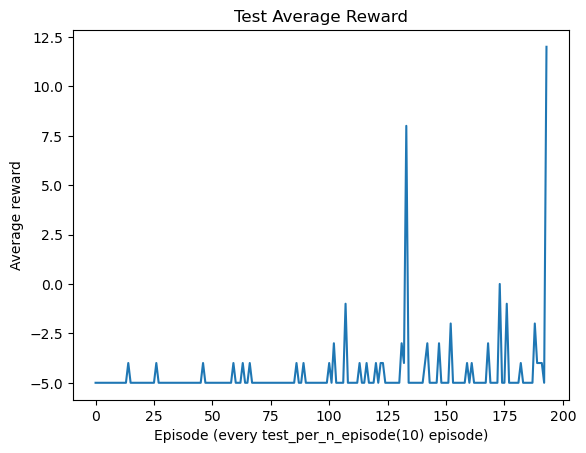

In [19]:
plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
plt.title('Test Average Reward')
plt.xlabel('Episode (every test_per_n_episode(10) episode)')
plt.ylabel('Average reward')
plt.show()

## Report

如上圖所示，要達到穩定至少飛過一根柱子，2000個episodes都還無法辦到，但仍有幾次有相對高的reward，其中我最後的結果是train 1930個episodes，
並且取得best reward = 12就停止(因為early stop是只要達到10)。可以發現前半段真的看起來像是無法train起來，但後半段就慢慢有進展。